# Análise de série temporal

In [1]:
# gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Dict
import matplotlib.ticker as mtick

In [2]:
# series temporais
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [3]:
df_mensal = pd.read_excel('../data/faturamento.xlsx', sheet_name='Mes', header=None)
df_mensal.columns = ['data', 'faturamento']
df_mensal['data'] = pd.to_datetime(df_mensal['data'])

In [4]:
df = df_mensal.set_index('data')
df = df.asfreq('MS')

In [5]:
df['log_faturamento'] = np.log(df['faturamento'])

In [6]:
def create_month_dummies(df, months_to_track):
    """
    Cria colunas dummy (0 ou 1) para os meses especificados.
    :param df: DataFrame com índice temporal.
    :param months_to_track: Lista de meses (números 1 a 12). Ex: [3, 11, 12].
    :return: DataFrame com as novas colunas dummy.
    """
    df_with_dummies = df.copy()
    
    # 1. Extrair o mês do índice
    months = df.index.month
    
    for month in months_to_track:
        col_name = f'mes_{month}'
        # Cria a coluna, 1 se o mês for o especificado, 0 caso contrário
        df_with_dummies[col_name] = (months == month).astype(int)
        
    return df_with_dummies

In [98]:
MONTHS_OF_INTEREST = list(range(1, 13))
df = create_month_dummies(df, MONTHS_OF_INTEREST)

## Detecção da estacionariedade

In [100]:
teste_adf = adfuller(df['faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.4842 (p-value: 0.0002)


In [101]:
teste_adf = adfuller(df['log_faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.1896 (p-value: 0.0007)


## Identificação

- AR (p)

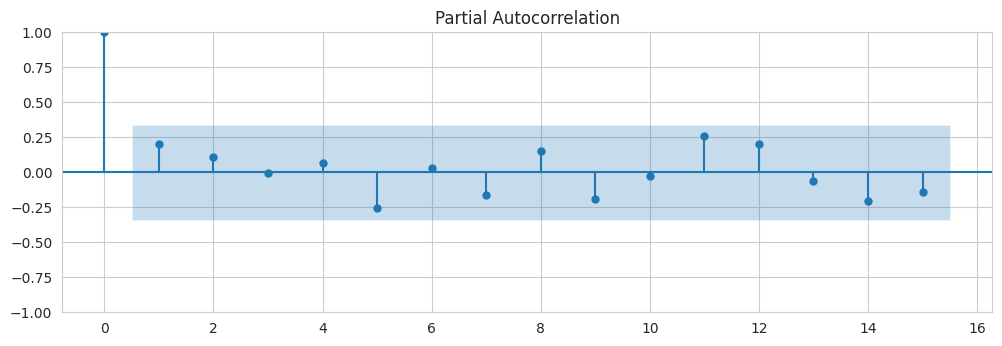

In [102]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'], lags=15, ax=ax1)

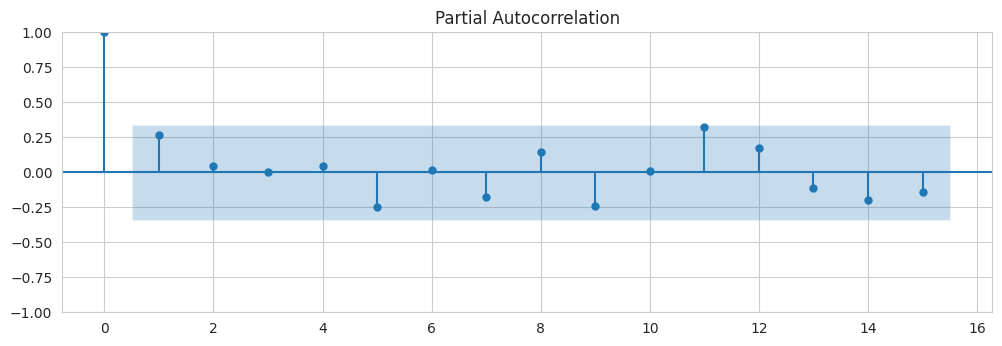

In [103]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']), lags=15, ax=ax1)

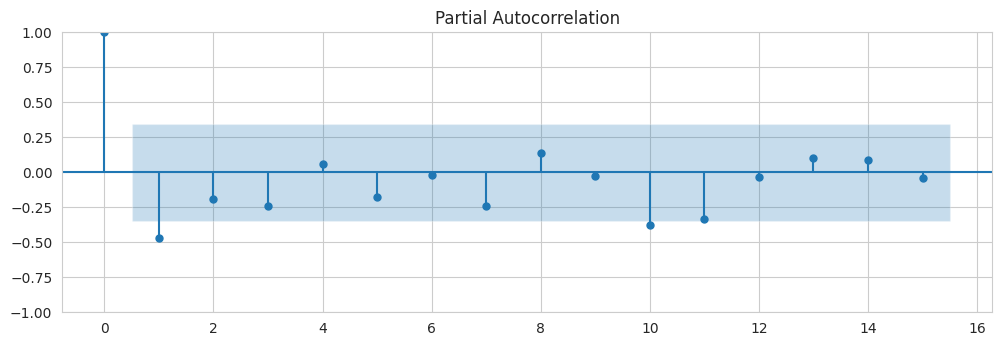

In [104]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

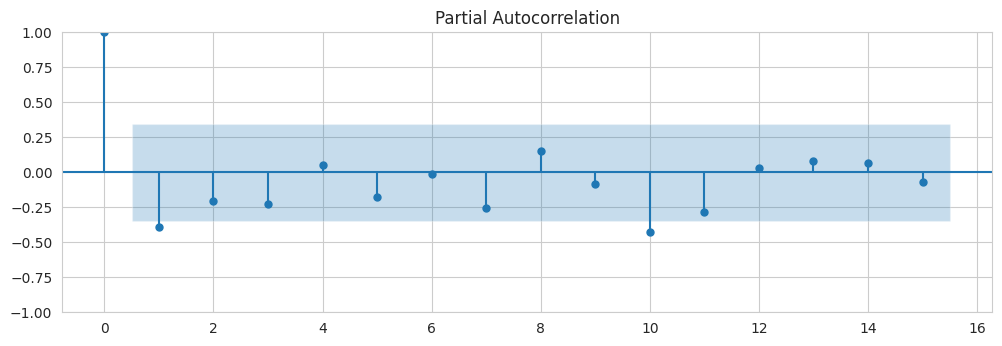

In [105]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

- MA(q)

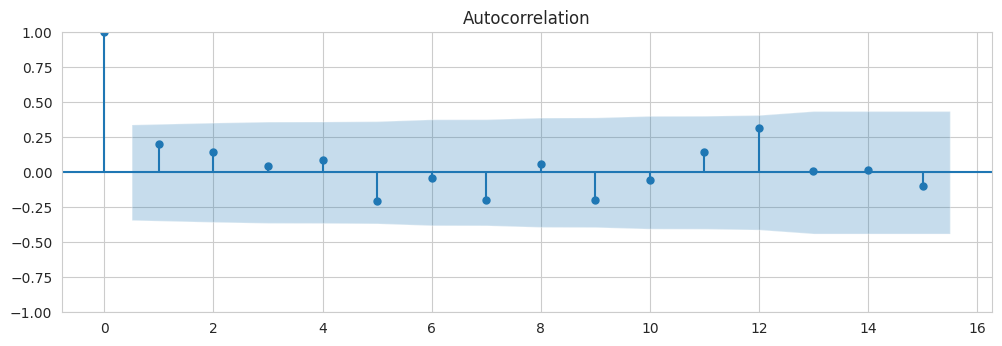

In [106]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'], lags=15, ax=ax1)

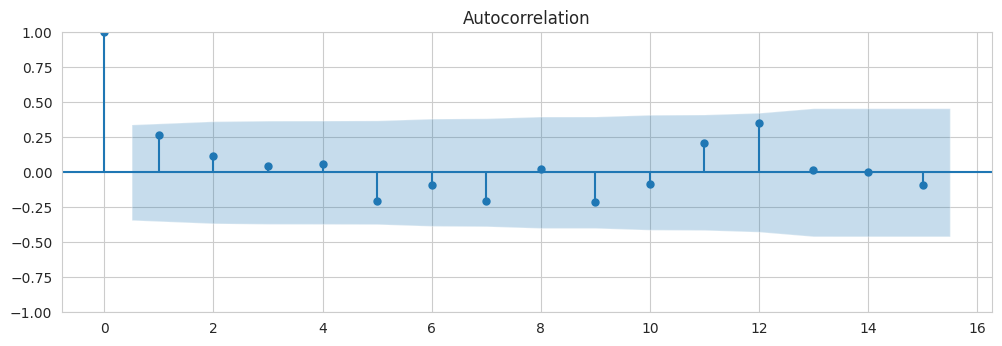

In [107]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']), lags=15, ax=ax1)

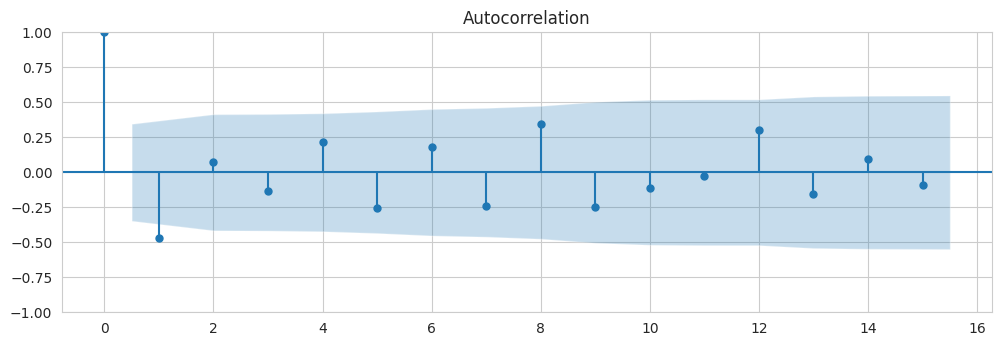

In [108]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

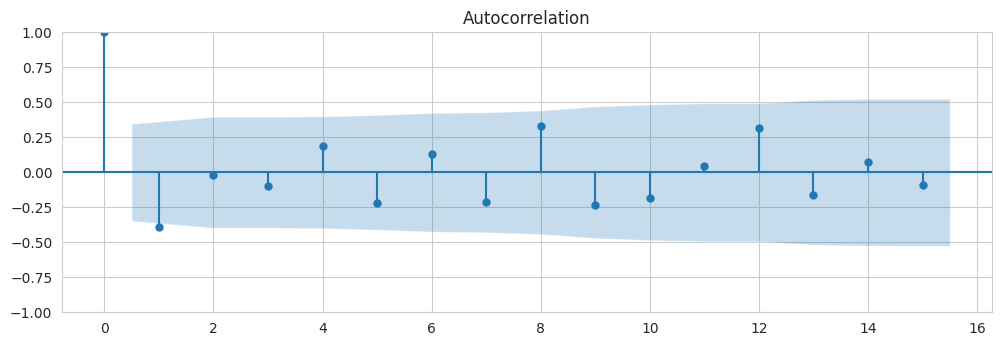

In [109]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

## Modelo Box-Jenkins

(vamos tentar mesmo assim)

In [110]:
def create_sparse_mask(ar_lags=None, ma_lags=None, sar_lags=None, sma_lags=None):
    """
    Cria os arrays de máscara de atividade (1 ativo, 0 fixo em zero) 
    para os lags AR e MA com base nas listas fornecidas.

    :param ar_lags: Lista de lags AR que DEVEM SER ATIVOS (ex: [1, 10]).
    :param ma_lags: Lista de lags MA que DEVEM SER ATIVOS (ex: [1]).
    :return: Quatro arrays (AR, MA, SAR, SMA) com 1 para ativo e 0 para fixo em zero.
    """
    
    # 1. Determinar as ordens máximas (p e q)
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    P = max(sar_lags) if sar_lags else 0
    Q = max(sma_lags) if sma_lags else 0
    
    # 2. Inicializar as máscaras com 0 (tudo inativo por padrão)
    ar_mask = np.zeros(p)
    ma_mask = np.zeros(q)
    sar_mask = np.zeros(P)
    sma_mask = np.zeros(Q)
    
    # 3. Marcar 1 nos lags que devem ser ATIVOS
    
    # Máscara AR
    if ar_lags:
        for lag in ar_lags:
            if lag > 0 and lag <= p:
                ar_mask[lag - 1] = 1 # O índice é lag - 1
                
    # Máscara MA
    if ma_lags:
        for lag in ma_lags:
            if lag > 0 and lag <= q:
                ma_mask[lag - 1] = 1
                
    # Máscaras Sazonais (mantidas em 0, pois você não as especificou como esparsas)
    
    return ar_mask, ma_mask, sar_mask, sma_mask

In [111]:
def build_sarimax_constraints(initial_model, ar_lags, ma_lags, num_exog=0):
    """
    Cria o dicionário de Kwargs para fixar em 0.0 os lags AR/MA indesejados, 
    garantindo que os parâmetros exógenos sejam estimados (não fixados).

    :param initial_model: Uma instância SARIMAX ajustada para obter os nomes dos parâmetros.
    :param ar_lags: Lista de lags AR ativos (ex: [1, 10]).
    :param ma_lags: Lista de lags MA ativos (ex: [1]).
    :param num_exog: Número de variáveis exógenas (len(exog_cols)).
    :return: Dicionário {nome_parametro: 0.0} para os lags fixos.
    """
    
    param_names = initial_model.param_names
    
    # 1. Definir o layout dos parâmetros no SARIMAX (aproximado):
    # [trend/const/intercept], [exog], [ar], [ma], [sar], [sma], [sigma2]
    
    # 2. Criar a máscara de status (1=Ativo, 0=Fixo em Zero)
    ar_mask_active, ma_mask_active, _, _ = create_sparse_mask(ar_lags, ma_lags)
    
    # 3. Mapear a máscara aos nomes dos parâmetros
    fixed_params_dict = {}
    current_idx = 0
    
    # --- Passo A: Pular Trend/Constante ---
    if param_names[current_idx] in ['const', 'trend', 'intercept']:
        current_idx += 1
        
    # --- Passo B: Pular Variáveis Exógenas ---
    # Os nomes dos parâmetros exógenos vêm logo após a constante.
    current_idx += num_exog
    
    # --- Passo C: Aplicar Máscara AR ---
    for i in range(len(ar_mask_active)):
        name = param_names[current_idx]
        if ar_mask_active[i] == 0:
            fixed_params_dict[name] = 0.0
        current_idx += 1
        
    # --- Passo D: Aplicar Máscara MA ---
    for i in range(len(ma_mask_active)):
        name = param_names[current_idx]
        if ma_mask_active[i] == 0:
            fixed_params_dict[name] = 0.0
        current_idx += 1
        
    # --- Passo E: Pular Sazonais e Sigma2 (variância) ---
    # O restante (SAR, SMA, Sigma2) não deve ser fixado em 0.0
    
    return fixed_params_dict

In [112]:
def train_sarimax(historico,
                  coluna_valor, 
                  include_constant = False,
                  order=(1, 1, 1), 
                  seasonal_order=(0, 0, 0, 0),
                  train_exog = None):
    
    model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
            
    # Ajustar o modelo (fit)
    model_fit = model.fit(disp=False) # disp=False para não imprimir o log de convergência

    return model_fit

In [113]:
def train_sarimax_sparse(historico,
                         coluna_valor, 
                         include_constant = False,
                         ar_lags=[1, 10], 
                         ma_lags=[1], 
                         d=1,
                         seasonal_order=(0, 0, 0, 0),
                         train_exog = None):
    
    # 1. Definir a ordem p, q e as máscaras fixas para o loop
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    order = (p, d, q)
    
    # Prepare sparse model
    prepare_model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    num_exog = 0
    if train_exog is not None and not train_exog.empty:
        num_exog = train_exog.shape[1]
        
    fixed_params_dict = build_sarimax_constraints(prepare_model, ar_lags, ma_lags, num_exog)

    if not fixed_params_dict and (p > len(ar_lags) or q > len(ma_lags)):
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")
    
    # 3. Ajustar o modelo usando a máscara
    model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Se a string estiver vazia, significa que não há restrições (todos os lags são ativos até p)
    if not fixed_params_dict:
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")

    model_fit = model.fit_constrained(disp=False, 
                                      constraints=fixed_params_dict, 
                                      method='lbfgs', maxiter=500)

    return model_fit

In [194]:
def rolling_forecast_sarimax(historico, coluna_valor, periodo_inicial, horizonte=1,
                             order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),
                             sparse_model = False, exp_adjust = False,
                             include_constant = False,
                             exog_cols = None,
                             display_parameters = True):
    """
    Realiza a validação Walk-Forward (Rolling Forecast) usando o modelo SARIMAX.
    (Com suporte a modelos esparsos, variáveis exógenas e ajuste exponencial)
    """
    if periodo_inicial >= len(historico):
        raise ValueError("O período inicial deve ser menor que o tamanho do histórico.")

    previsoes = []
    reais = []
    indices_previstos = []

    # ------------------ INÍCIO DO LOOP DE ROLLING ------------------
    for i in range(periodo_inicial, len(historico) - horizonte + 1):
        
        # 1. Definir Treinamento e Real
        train = historico.iloc[:i]
        real_slice = historico.iloc[i : i + horizonte]
        
        # 1.1. Fatiar Variáveis Exógenas (se existirem)
        train_exog = None
        predict_exog = None
        if exog_cols:
            # Exógenas para o Treinamento
            train_exog = train[exog_cols]
            # Exógenas para a Previsão (os valores futuros)
            predict_exog = real_slice[exog_cols]
            
        # 2. Treinar o Modelo SARIMAX
        try:
            if sparse_model is False:
                model_fit = train_sarimax(train, coluna_valor,
                                          include_constant=include_constant,
                                          order=order, seasonal_order=seasonal_order,
                                          train_exog=train_exog)
            else:
                ar_lags, ma_lags, d = order
                model_fit = train_sarimax_sparse(train, coluna_valor,
                                                 include_constant=include_constant,
                                                 ar_lags=ar_lags,
                                                 ma_lags=ma_lags,
                                                 d=d,
                                                 seasonal_order=seasonal_order,
                                                 train_exog=train_exog)
            
            # 3. Gerar a Previsão
            idx_start = real_slice.index[0]
            idx_end = real_slice.index[-1]

            # print(idx_start, idx_end)
            # display(predict_exog)

            # A previsão deve receber o predict_exog se houver
            previsao_h = model_fit.predict(start=idx_start, end=idx_end, exog=predict_exog)
            
            previsoes.extend(previsao_h.tolist())
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

            # print(reais)
            # print(previsoes)
            # print(indices_previstos)
            
        except Exception as e:
            print(f"Erro ao ajustar o SARIMAX no passo {i} (Treino até {train.index[-1]}): {e}")
            previsoes.extend([np.nan] * horizonte)
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

    # ------------------ FIM DO LOOP DE ROLLING ------------------

    # --- 4. Avaliação das Métricas ---
    if display_parameters:
        display(model_fit.summary())
    
    if exp_adjust:
        # AVALIAÇÃO CORRETA: O exp() deve ser feito apenas nos arrays numpy
        previsoes = np.exp(np.array(previsoes))
        reais = np.exp(np.array(reais))
    else:
        previsoes = np.array(previsoes)
        reais = np.array(reais)
        
    # Recalculando o df_resultados com os arrays possivelmente transformados
    df_resultados = pd.DataFrame({
        'data': indices_previstos,
        'real': reais,
        'previsao': previsoes
    }).set_index('data').dropna()
    
    # ... (Cálculo das métricas MAE, RMSE, MAPE e retorno) ...
    reais_ = df_resultados['real'].values
    previsoes_ = df_resultados['previsao'].values

    mae = mean_absolute_error(reais_, previsoes_)
    rmse = np.sqrt(mean_squared_error(reais_, previsoes_))
    # Proteção contra divisão por zero para MAPE
    mape = np.mean(np.abs(reais_ - previsoes_) / np.maximum(np.abs(reais_), 1e-8)) * 100

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    print(f"Rolling Forecast SARIMAX (h={horizonte}, Order={order}) -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}%")
    
    return metrics, df_resultados

## Modelos

In [195]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [196]:
def format_currency_millions(x, pos):
    """Função para formatar valores do eixo Y como R$ X.X M."""
    if x >= 1e6:
        return f'R$ {x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x*1e-3:.1f}K'
    else:
        return f'R$ {x:,.0f}'

In [197]:
def format_currency_annotation(value):
    """Função para formatar valores em anotações (ex: R$ 33.4M)."""
    if value >= 1e6:
        return f'R$ {value*1e-6:.1f}M'
    else:
        return f'R$ {value:,.0f}'

In [198]:
def plot_forecast_results(historico_completo, df_resultados, coluna_valor, metricas, titulo="Série Temporal e Previsões"):
    """
    Gera um gráfico Matplotlib comparando Real vs. Previsto do Rolling Forecast
    """
    
    # 1. Preparação dos Dados
    
    # Historico completo (série de valores reais)
    df_real = historico_completo.reset_index()
    # print(df_real.columns)
    # df_real.columns = ['data', 'valor_real']

    # DataFrame de Previsões (apenas onde o forecast foi calculado)
    df_previsto = df_resultados.reset_index()
    df_previsto.columns = ['data', 'valor_real_previsto', 'previsao']
    
    
    # 2. Configuração do Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- 3. Plotagem do Valor Real ---
    ax.plot(
        df_real['data'], 
        df_real['valor_real'], 
        label=f'{coluna_valor.capitalize()} Real',
        marker='o', 
        linestyle='-', 
        color='C0'
    )

    # --- 4. Plotagem da Previsão ---
    # Plota a previsão a partir do primeiro ponto previsto
    ax.plot(
        df_previsto['data'], 
        df_previsto['previsao'], 
        label=f'{coluna_valor.capitalize()} Previsto',
        marker='o', 
        linestyle='--', # Linha tracejada para diferenciar
        color='red' 
    )
    
    # --- 5. Formatação dos Eixos ---
    
    # Eixo X (Datas)
    ax.set_xlabel("Data", fontsize=12)
    
    # Formatação de data (ajustar conforme a granularidade dos seus dados)
    # Se for mensal, podemos formatar como 'AAAA-MM'
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    
    # Eixo Y (Valores)
    ax.set_ylabel(coluna_valor.capitalize(), fontsize=12)
    formatter = mtick.FuncFormatter(format_currency_millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Título e Legendas
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)

    # Formatação do texto da métrica
    metrics_text = (
        f"Métricas de Erro:\n"
        f"MAE: {metricas.get('MAE', 0):,.2f}\n"
        f"RMSE: {metricas.get('RMSE', 0):,.2f}\n"
        f"MAPE: {metricas.get('MAPE', 0):,.2f}%"
    )
    
    # Adicionar o texto como um 'bbox' (bounding box) para destaque
    ax.text(
        0.98, 0.95, 
        metrics_text, 
        transform=ax.transAxes, # Usa coordenadas relativas (0 a 1)
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6, edgecolor='black')
    )
    
    plt.tight_layout()
    plt.show()

In [199]:
coluna = 'faturamento'
coluna_log = 'log_faturamento'
periodo_treino_minimo = 24
horizonte_previsao = 3

# Seus parâmetros: AR(1 e 10), I(1), MA(1) -> Order=(10, 1, 1)
sarimax_order = (10, 1, 1) 
sarimax_seasonal = (0, 0, 0, 0)
sarimax_sparse_order = ([1, 10], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
# EXOG_COLS = [f'mes_{m}' for m in [3, 11, 12]]

### ARIMA(10, 1, 1)

In [200]:
metricas_sarimax, df_resultados_sarimax = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                -273.262
Date:                Fri, 31 Oct 2025   AIC                            570.524
Time:                        19:24:59   BIC                            581.857
Sample:                    01-01-2023   HQIC                           572.442
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4803      0.528     -0.910      0.363      -1.515       0.555
ar.L2         -0.1411      0.377     -0.374      0.708      -0.879       0.597
ar.L3         -0.4729      0.314     -1.505      0.132      -1.089       0.143
ar.L4         -0.1922      0.279     -0.689      0.491      -0.739       0.355
ar.L5         -0.4416      0.421     -1.049      0.294      -1.267       0.384
ar.L6         -0.2521      0.233     -1.083      0.279      -0.709       0.204
ar.L7         -0.0953      0.344     -0.277      0.782      -0.770       0.579
ar.L8         -0.3626      0.544     -0.666      0.505      -1.429       0.704
ar.L9         -0.1112      0.268     -0.415      0.678      -0.636       0.414
ar.L10        -0.7869      0.447     -1.762      0.078      -1.662       0.088
ma.L1         -0.5297      0.244     -2.175      0.030      -1.007      -0.052
sigma2      2.211e+11   1.82e-12   1.22e+23      0.000    2.21e+11    2.21e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.41   Prob(JB):                         0.75
Heteroskedasticity (H):               5.87   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.66e+39. Standard errors may be unstable.
"""

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 837,177.36 | RMSE: 1,028,784.96 | MAPE: 26.39%


In [201]:
metricas_sarimax1, df_resultados_sarimax1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                -301.827
Date:                Fri, 31 Oct 2025   AIC                            627.654
Time:                        19:25:09   BIC                            640.188
Sample:                    01-01-2023   HQIC                           630.374
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3371      0.583     -0.578      0.563      -1.479       0.805
ar.L2         -0.1623      0.430     -0.378      0.706      -1.005       0.680
ar.L3         -0.3964      0.308     -1.285      0.199      -1.001       0.208
ar.L4         -0.1250      0.279     -0.448      0.654      -0.672       0.422
ar.L5         -0.4316      0.624     -0.692      0.489      -1.654       0.790
ar.L6         -0.2241      0.227     -0.986      0.324      -0.670       0.222
ar.L7         -0.2960      0.303     -0.979      0.328      -0.889       0.297
ar.L8         -0.1346      0.342     -0.393      0.694      -0.806       0.537
ar.L9         -0.2361      0.219     -1.077      0.281      -0.666       0.194
ar.L10        -0.6061      0.461     -1.314      0.189      -1.510       0.298
ma.L1         -0.5026      0.262     -1.915      0.056      -1.017       0.012
sigma2      2.048e+11   4.37e-12   4.69e+22      0.000    2.05e+11    2.05e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.39   Prob(JB):                         0.75
Heteroskedasticity (H):               7.05   Skew:                             0.32
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+39. Standard errors may be unstable.
"""

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 698,822.46 | RMSE: 904,959.03 | MAPE: 22.05%


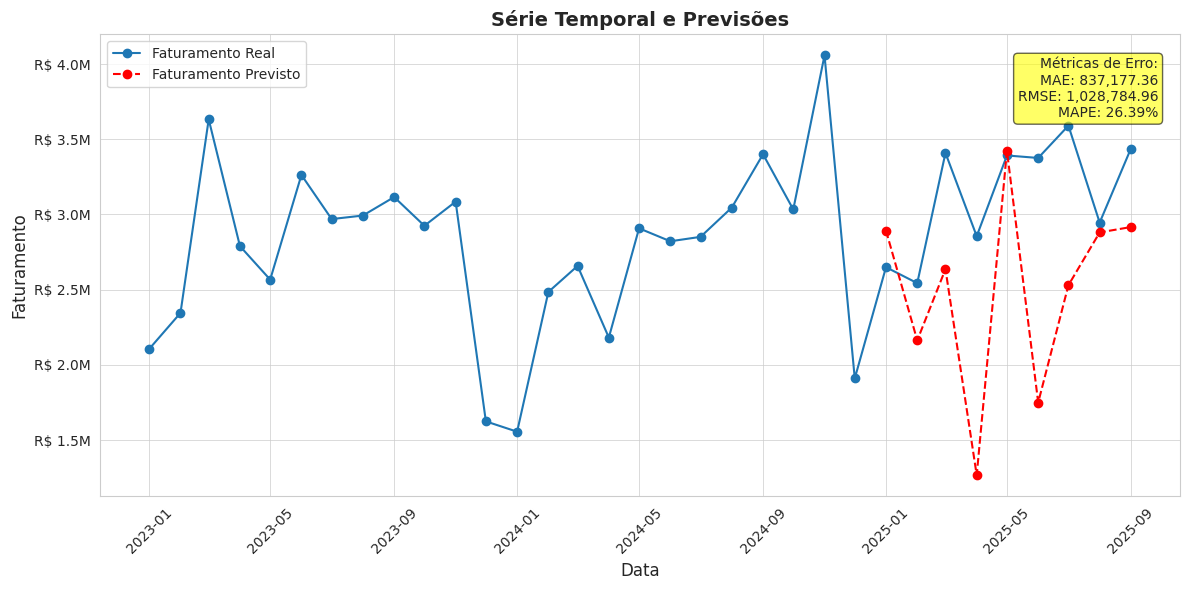

In [202]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax1,
    coluna,
    metricas_sarimax
)

### ARIMA(10, 1, 1) restrito

In [203]:
metricas_sarimax_sparse, df_resultados_sarimax_sparse = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                -279.601
Date:                Fri, 31 Oct 2025   AIC                            567.201
Time:                        19:25:10   BIC                            570.979
Sample:                    01-01-2023   HQIC                           567.841
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.3224      0.195     -1.653      0.098      -0.705       0.060
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10           -0.5905      0.132     -4.480      0.000      -0.849      -0.332
ma.L1            -0.4676      0.184     -2.541      0.011      -0.828      -0.107
sigma2         2.211e+11   2.38e-13   9.28e+23      0.000    2.21e+11    2.21e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.98   Prob(JB):                         0.47
Heteroskedasticity (H):               1.24   Skew:                            -0.68
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.07e+39. Standard errors may be unstable.
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 649,661.76 | RMSE: 719,688.14 | MAPE: 19.89%


In [204]:
metricas_sarimax_sparse1, df_resultados_sarimax_sparse1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                -309.425
Date:                Fri, 31 Oct 2025   AIC                            626.849
Time:                        19:25:10   BIC                            631.028
Sample:                    01-01-2023   HQIC                           627.756
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.2989      0.177     -1.685      0.092      -0.646       0.049
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10           -0.5315      0.119     -4.467      0.000      -0.765      -0.298
ma.L1            -0.4825      0.157     -3.079      0.002      -0.790      -0.175
sigma2         2.048e+11   1.53e-13   1.33e+24      0.000    2.05e+11    2.05e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.95   Prob(JB):                         0.43
Heteroskedasticity (H):               1.27   Skew:                            -0.66
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+39. Standard errors may be unstable.
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 606,375.48 | RMSE: 657,121.12 | MAPE: 19.16%


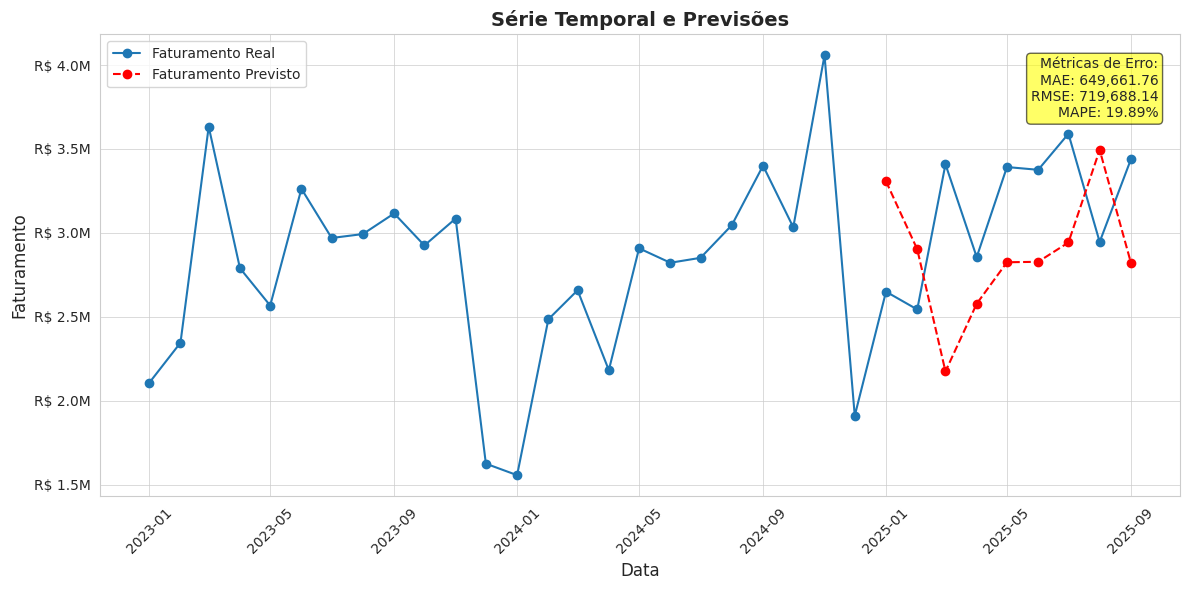

In [205]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse1,
    coluna,
    metricas_sarimax_sparse
)

### ARIMA(10, 1, 1) log

In [206]:
metricas_sarimax_log, df_resultados_sarimax_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   4.976
Date:                Fri, 31 Oct 2025   AIC                             14.049
Time:                        19:25:12   BIC                             25.382
Sample:                    01-01-2023   HQIC                            15.967
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2862      0.836     -0.342      0.732      -1.924       1.352
ar.L2         -0.2203      0.651     -0.338      0.735      -1.497       1.056
ar.L3         -0.3734      0.368     -1.015      0.310      -1.094       0.348
ar.L4         -0.1618      0.440     -0.368      0.713      -1.024       0.701
ar.L5         -0.4100      0.738     -0.555      0.579      -1.857       1.037
ar.L6         -0.2173      0.280     -0.776      0.438      -0.766       0.332
ar.L7         -0.3425      0.636     -0.539      0.590      -1.589       0.904
ar.L8         -0.0320      0.414     -0.077      0.938      -0.843       0.779
ar.L9         -0.3450      0.197     -1.753      0.080      -0.731       0.041
ar.L10        -0.5634      0.539     -1.045      0.296      -1.620       0.493
ma.L1         -0.4354      1.158     -0.376      0.707      -2.705       1.834
sigma2         0.0343      0.039      0.885      0.376      -0.042       0.110
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.75   Prob(JB):                         0.61
Heteroskedasticity (H):               0.98   Skew:                            -0.56
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 785,593.65 | RMSE: 950,314.06 | MAPE: 24.92%


In [207]:
metricas_sarimax_log1, df_resultados_sarimax_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   6.473
Date:                Fri, 31 Oct 2025   AIC                             11.054
Time:                        19:25:13   BIC                             23.588
Sample:                    01-01-2023   HQIC                            13.774
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3289      0.784     -0.419      0.675      -1.866       1.208
ar.L2         -0.2191      0.517     -0.424      0.672      -1.232       0.794
ar.L3         -0.3942      0.311     -1.269      0.204      -1.003       0.215
ar.L4         -0.1684      0.371     -0.454      0.650      -0.896       0.559
ar.L5         -0.4096      0.592     -0.692      0.489      -1.570       0.751
ar.L6         -0.2419      0.251     -0.964      0.335      -0.734       0.250
ar.L7         -0.3537      0.460     -0.770      0.442      -1.254       0.547
ar.L8         -0.1014      0.366     -0.277      0.782      -0.819       0.616
ar.L9         -0.3286      0.168     -1.955      0.051      -0.658       0.001
ar.L10        -0.6058      0.495     -1.223      0.221      -1.577       0.365
ma.L1         -0.3872      1.003     -0.386      0.699      -2.352       1.578
sigma2         0.0314      0.030      1.042      0.298      -0.028       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.74   Prob(JB):                         0.40
Heteroskedasticity (H):               0.85   Skew:                            -0.67
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 686,125.23 | RMSE: 844,325.76 | MAPE: 22.05%


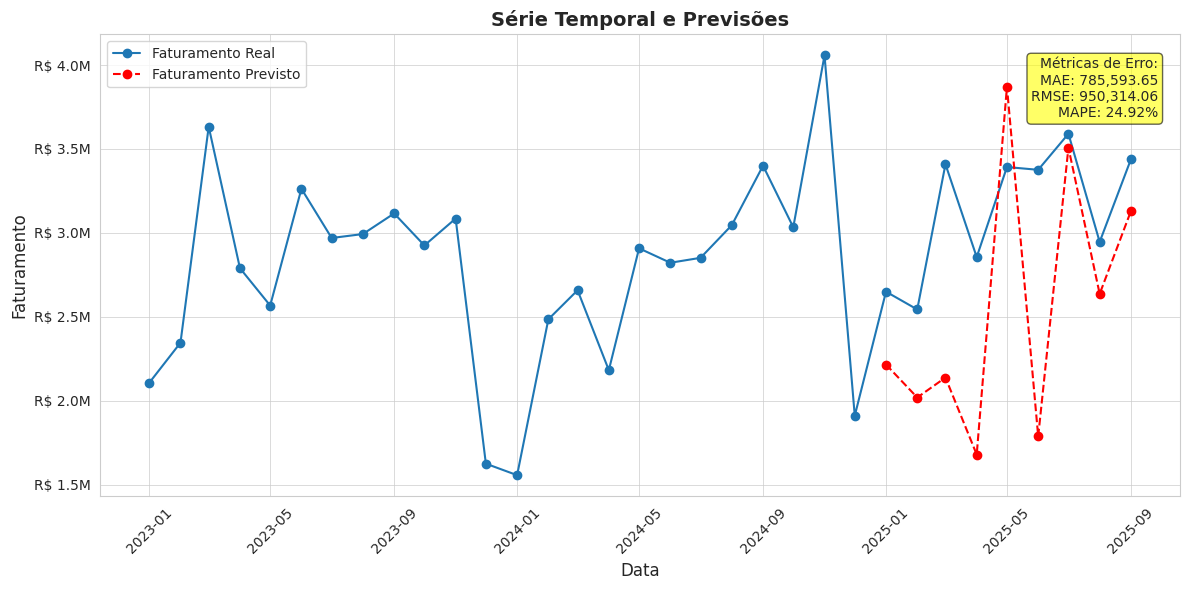

In [208]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_log1,
    coluna,
    metricas_sarimax_log
)

### ARIMA(10, 1, 1) log restrito

In [209]:
metricas_sarimax_sparse_log, df_resultados_sarimax_sparse_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   0.574
Date:                Fri, 31 Oct 2025   AIC                              6.852
Time:                        19:25:14   BIC                             10.630
Sample:                    01-01-2023   HQIC                             7.492
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.2899      0.373     -0.777      0.437      -1.021       0.441
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10           -0.5312      0.215     -2.465      0.014      -0.954      -0.109
ma.L1            -0.3691      0.592     -0.624      0.533      -1.528       0.790
sigma2            0.0547      0.025      2.151      0.032       0.005       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.86   Prob(JB):                         0.26
Heteroskedasticity (H):               0.45   Skew:                            -0.92
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 602,545.05 | RMSE: 704,835.08 | MAPE: 18.14%


In [210]:
metricas_sarimax_sparse_log1, df_resultados_sarimax_sparse_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   32
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   1.122
Date:                Fri, 31 Oct 2025   AIC                              5.756
Time:                        19:25:14   BIC                              9.934
Sample:                    01-01-2023   HQIC                             6.663
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.2529      0.324     -0.781      0.435      -0.887       0.381
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10           -0.4777      0.212     -2.252      0.024      -0.894      -0.062
ma.L1            -0.4177      0.468     -0.892      0.372      -1.335       0.500
sigma2            0.0521      0.023      2.262      0.024       0.007       0.097
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.94
Prob(Q):                              0.84   Prob(JB):                         0.23
Heteroskedasticity (H):               0.51   Skew:                            -0.91
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 483,044.76 | RMSE: 588,160.61 | MAPE: 14.72%


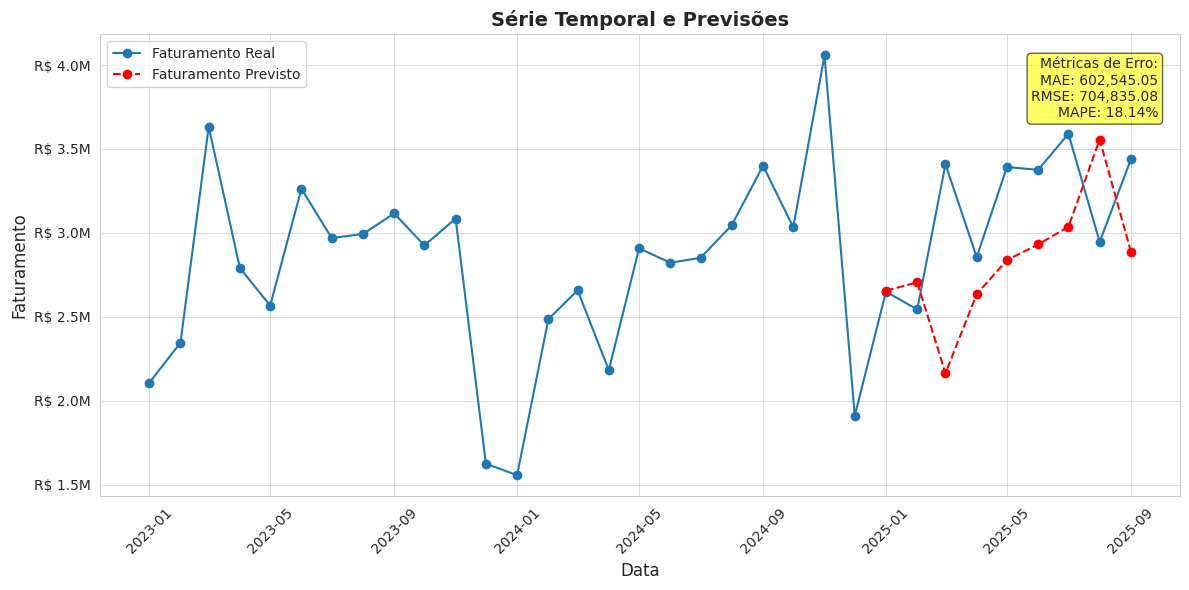

In [211]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_log1,
    coluna,
    metricas_sarimax_sparse_log
)

In [276]:
sarimax_order = (1, 1, 1) 
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [277]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = False,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:               SARIMAX(1, 1, 1)   Log Likelihood                   6.824
Date:                Fri, 31 Oct 2025   AIC                             -5.649
Time:                        19:49:21   BIC                             -0.465
Sample:                    01-01-2023   HQIC                            -4.107
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mes_1         -0.5622      0.206     -2.735      0.006      -0.965      -0.159
ar.L1         -0.5764      0.371     -1.556      0.120      -1.303       0.150
ma.L1         -0.5626      0.227     -2.482      0.013      -1.007      -0.118
sigma2         0.0352      0.007      4.942      0.000       0.021       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                23.12
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -1.69
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(1, 1, 1)) -> MAE: 303,082.63 | RMSE: 385,039.88 | MAPE: 9.63%


### ARIMA(10, 1, 1) log restrito com endógenas

In [278]:
sarimax_sparse_order = ([1, 5], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [279]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   30
Model:               SARIMAX(5, 1, 1)   Log Likelihood                   5.296
Date:                Fri, 31 Oct 2025   AIC                             -0.592
Time:                        19:49:43   BIC                              5.298
Sample:                    01-01-2023   HQIC                             0.970
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mes_1            -0.5554      0.213     -2.609      0.009      -0.973      -0.138
ar.L1            -0.6275      0.358     -1.751      0.080      -1.330       0.075
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5            -0.0005      0.019     -0.028      0.978      -0.039       0.038
ma.L1            -0.4876      0.259     -1.879      0.060      -0.996       0.021
sigma2            0.0373      0.009      4.238      0.000       0.020       0.055
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                22.43
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -1.79
Prob(H) (two-sided):                  0.70   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 280,672.22 | RMSE: 350,321.27 | MAPE: 8.85%


In [280]:
metricas_sarimax_sparse_endog_log1, df_resultados_sarimax_sparse_endog_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   32
Model:               SARIMAX(5, 1, 1)   Log Likelihood                   6.450
Date:                Fri, 31 Oct 2025   AIC                             -2.899
Time:                        19:49:44   BIC                              3.391
Sample:                    01-01-2023   HQIC                            -1.088
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mes_1            -0.5500      0.217     -2.536      0.011      -0.975      -0.125
ar.L1            -0.6247      0.358     -1.745      0.081      -1.327       0.077
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5            -0.0300      0.301     -0.100      0.921      -0.620       0.560
ma.L1            -0.4833      0.240     -2.013      0.044      -0.954      -0.013
sigma2            0.0353      0.007      4.747      0.000       0.021       0.050
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                25.14
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -1.77
Prob(H) (two-sided):                  0.55   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 5], [1], 1)) -> MAE: 311,522.78 | RMSE: 387,415.31 | MAPE: 10.36%


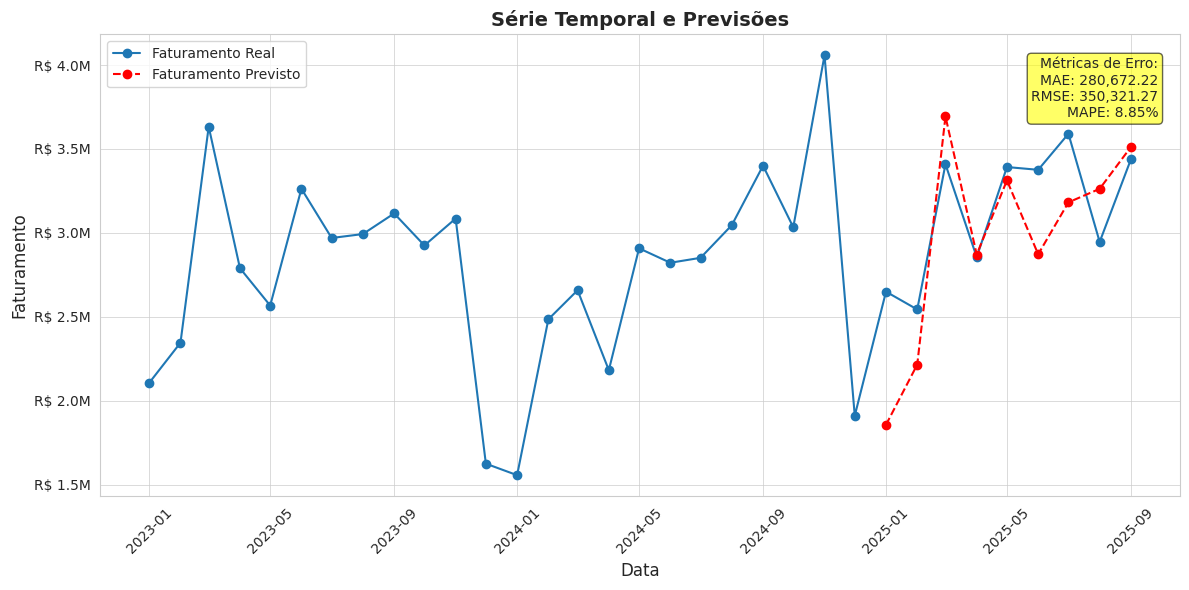

In [281]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_endog_log1,
    coluna,
    metricas_sarimax_sparse_endog_log
)

## Tunning

In [249]:
sarimax_sparse_order = ([1, 5], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [ ]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

In [254]:
from itertools import product

In [256]:
def fine_tune_sarimax(historico, coluna_valor, periodo_inicial, horizonte,
                      ar_lags_options, ma_lags_options, d_options, seasonal_options, exog_options):
    """
    Realiza um Grid Search para encontrar a melhor combinação de parâmetros SARIMAX esparsos e exógenas.
    """
    
    # Desabilita a exibição do summary a cada iteração
    display_parameters = False 
    
    # 1. Preparação para o Grid Search
    
    # Cria o grid completo de combinações (produto cartesiano)
    param_grid = list(product(ar_lags_options, ma_lags_options, d_options, seasonal_options, exog_options))
    
    results = []
    
    print(f"Iniciando Grid Search com {len(param_grid)} combinações...")
    
    # 2. Loop sobre o Grid
    for ar_lags, ma_lags, d, seasonal_order, months_exog in param_grid:
        
        try:
            # 2.1. Configuração do Modelo
            
            # A ordem é necessária para a função rolling_forecast_sarimax
            order = (ar_lags, ma_lags, d)
            
            # Variáveis Exógenas
            exog_cols = [f'mes_{m}' for m in months_exog]
            
            # Se houver exógenas, o histórico deve ser preparado
            if exog_cols:
                # Função auxiliar para criar as dummies (deve estar definida)
                df_temp = create_month_dummies(historico, months_exog) 
            else:
                df_temp = historico.copy()
            
            # 2.2. Execução do Rolling Forecast
            
            metrics, _ = rolling_forecast_sarimax(
                df_temp, 
                coluna_valor, 
                periodo_inicial, 
                horizonte,
                order=order, 
                seasonal_order=seasonal_order,
                sparse_model=True,  # Força o uso do modelo esparso
                include_constant=False,
                exog_cols=exog_cols,
                 exp_adjust = True,
                display_parameters=display_parameters
            )
            
            # 2.3. Armazenamento dos Resultados
            
            results.append({
                'ar_lags': ar_lags,
                'ma_lags': ma_lags,
                'd': d,
                'seasonal_order': seasonal_order,
                'exog_months': months_exog,
                'MAPE': metrics['MAPE'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE']
            })
            
        except Exception as e:
            # Captura falhas de ajuste do modelo (comum no SARIMAX)
            print(f"Falha na combinação AR={ar_lags}, MA={ma_lags}, D={d}, Exog={months_exog}: {e}")
            results.append({
                'ar_lags': ar_lags,
                'ma_lags': ma_lags,
                'd': d,
                'seasonal_order': seasonal_order,
                'exog_months': months_exog,
                'MAPE': np.nan, 'RMSE': np.nan, 'MAE': np.nan
            })

    # 3. Análise dos Resultados
    df_results = pd.DataFrame(results).sort_values(by='MAPE', ascending=True).reset_index(drop=True)
    
    best_model = df_results.iloc[0]
    
    print("\n--- MELHOR MODELO ENCONTRADO ---")
    print(f"MAPE Mínimo: {best_model['MAPE']:.2f}%")
    print(f"AR Lags: {best_model['ar_lags']}")
    print(f"MA Lags: {best_model['ma_lags']}")
    print(f"I: {best_model['d']}")
    print(f"Sazonal: {best_model['seasonal_order']}")
    print(f"Exógenas: {best_model['exog_months']}")
    
    return df_results, best_model

In [258]:
# DEFINIÇÃO DO GRID
AR_LAGS_OPTIONS = [[1], [1, 5], [1, 10]]
MA_LAGS_OPTIONS = [[1], [1, 2]]
D_OPTIONS = [1]
SEASONAL_OPTIONS = [(0, 0, 0, 0), (1, 0, 0, 12)]
EXOG_OPTIONS = [[], [1], [3], [1, 3], [1, 5], [1, 3, 11, 12]]

# EXECUÇÃO
df_tuning_results, melhor_modelo = fine_tune_sarimax(
    historico=df,
    coluna_valor='log_faturamento',
    periodo_inicial=24,
    horizonte=3,
    ar_lags_options=AR_LAGS_OPTIONS,
    ma_lags_options=MA_LAGS_OPTIONS,
    d_options=D_OPTIONS,
    seasonal_options=SEASONAL_OPTIONS,
    exog_options=EXOG_OPTIONS
)

Iniciando Grid Search com 72 combinações...
Erro ao ajustar o SARIMAX no passo 24 (Treino até 2024-12-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 25 (Treino até 2025-01-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 26 (Treino até 2025-02-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 27 (Treino até 2025-03-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 28 (Treino até 2025-04-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 29 (Treino até 2025-05-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 30 (Treino até 2025-06-01 00:00:00): A 

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 531,438.52 | RMSE: 639,135.06 | MAPE: 16.77%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 693,158.77 | RMSE: 845,451.02 | MAPE: 21.81%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 602,775.49 | RMSE: 744,466.55 | MAPE: 19.05%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 472,509.14 | RMSE: 535,847.05 | MAPE: 15.23%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 563,700.53 | RMSE: 661,903.02 | MAPE: 18.00%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 551,877.94 | RMSE: 639,083.10 | MAPE: 17.02%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 411,913.63 | RMSE: 507,841.38 | MAPE: 12.94%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 473,232.92 | RMSE: 530,533.50 | MAPE: 14.45%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 334,887.84 | RMSE: 463,775.26 | MAPE: 10.84%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 371,914.15 | RMSE: 453,438.48 | MAPE: 11.76%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 532,205.64 | RMSE: 599,906.28 | MAPE: 17.25%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 642,287.49 | RMSE: 881,159.21 | MAPE: 20.13%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 497,629.55 | RMSE: 580,701.65 | MAPE: 15.80%
Roll

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 677,161.73 | RMSE: 792,052.61 | MAPE: 21.93%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 602,545.05 | RMSE: 704,835.08 | MAPE: 18.14%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 477,401.79 | RMSE: 688,126.17 | MAPE: 14.59%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 647,163.25 | RMSE: 751,714.68 | MAPE: 19.56%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 481,239.17 | RMSE: 743,497.28 | MAPE: 14.69%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 449,726.18 | RMSE: 621,220.30 | MAPE: 13.81%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 539,863.17 | RMSE: 615,372.84 | MAPE: 17.28%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 385,695.23 | RMSE: 453,685.23 | MAPE: 12.36%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 617,552.70 | RMSE: 753,833.66 | MAPE: 19.35%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 538,256.56 | RMSE: 665,374.87 | MAPE: 16.92%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 529,943.27 | RMSE: 615,351.17 | MAPE: 16.66%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 585,375.99 | RMSE: 739,944.70 | MAPE: 18.38%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 664,580.68 | RMSE: 799,385.06 | MAPE: 20.98%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 641,541.73 | RMSE: 749,523.22 | MAPE: 19.45%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 534,050.65 | RMSE: 711,103.08 | MAPE: 16.31%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 656,704.01 | RMSE: 777,000.67 | MAPE: 19.88%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 540,208.50 | RMSE: 709,024.39 | MAPE: 16.49%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 528,847.26 | RMSE: 676,711.01 | MAPE: 16.30%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 508,760.93 | RMSE: 582,851.09 | MAPE: 16.20%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 367,077.67 | RMSE: 437,232.71 | MAPE: 11.83%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 445,730.12 | RMSE: 515,679.80 | MAPE: 14.08%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 562,245.58 | RMSE: 691,448.06 | MAPE: 17.62%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 376,233.23 | RMSE: 425,975.41 | MAPE: 11.95%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 516,838.12 | RMSE: 615,057.93 | MAPE: 16.15%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 659,676.95 | RMSE: 790,997.05 | MAPE: 20.85%

--- MELHOR MODELO ENCONTRADO ---
MAPE Mínimo: 8.85%
AR Lags: [1, 5]
MA Lags: [1]
I: 1
Sazonal: (0, 0, 0, 0)
Exógenas: [1]


In [ ]:
df_tuning_results, melhor_modelo

In [259]:
df_tuning_results

,ar_lags,ma_lags,d,seasonal_order,exog_months,MAPE,RMSE,MAE
0,"[1, 5]",[1],1,"(0, 0, 0, 0)",[1],8.850147,350321.267976,280672.220877
1,"[1, 5]",[1],1,"(0, 0, 0, 0)","[1, 5]",9.101869,359344.615184,288987.546489
2,"[1, 5]",[1],1,"(0, 0, 0, 0)","[1, 3]",10.364729,435215.417043,321510.200637
3,"[1, 5]","[1, 2]",1,"(0, 0, 0, 0)","[1, 3]",10.840674,463775.261066,334887.840104
4,"[1, 5]","[1, 2]",1,"(0, 0, 0, 0)","[1, 5]",11.761833,453438.484328,371914.145213
...,...,...,...,...,...,...,...,...
67,[1],"[1, 2]",1,"(1, 0, 0, 12)",[1],NaN,NaN,NaN
68,[1],"[1, 2]",1,"(1, 0, 0, 12)",[3],NaN,NaN,NaN
69,[1],"[1, 2]",1,"(1, 0, 0, 12)","[1, 3]",NaN,NaN,NaN
70,[1],"[1, 2]",1,"(1, 0, 0, 12)","[1, 5]",NaN,NaN,NaN
